In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [2]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [3]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

In [30]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 100
num_steps = 25
batch_size = 64*num_steps

In [5]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [6]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

# Graph 

In [31]:
tf.reset_default_graph()

In [32]:
#----------input layer-----------------------
x = tf.placeholder(tf.int64, [None, num_steps])
y = tf.placeholder(tf.int64, [None, num_steps])
#init_state = tf.placeholder(tf.float32,[None, num_neurons])
learning_rate = tf.placeholder(tf.float32,[])

embeddings = tf.get_variable('embedding_matrix', [vocab_size, num_neurons])

# Tensor of dims batch_size //num_steps x num_steps x num_neurons
x_transformed = tf.nn.embedding_lookup(embeddings, x)


#----------hidden layer-----------------------
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
init_state = cell.zero_state(batch_size//num_steps,tf.float32)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_transformed, initial_state=init_state, dtype=tf.float32)


#----------output layer-----------------------
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.0, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

#----------loss and accuracy------------------
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 2),y), tf.float32))

#----------Trainer------------------
trainOp = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss)
init_vars = tf.initialize_all_variables()


# Training

In [37]:
print_after_num_steps = 100
adaptive_learning_rate = 0.1
restart_training = False

if restart_training:
    training_state = None
    trainHist = []
    accHist = []
    sess = tf.Session()
    sess.run(init_vars)

for num_epoch, epoch in enumerate(gen_epochs(raw_text_enc[:1000*batch_size],1,batch_size,num_steps)):
    
    if num_epoch > 50:
        adaptive_learning_rate = 0.01
    
    for i, batch in enumerate(epoch):
        
        feed_dic = {x: batch[0], y: batch[1], learning_rate: adaptive_learning_rate}
        if training_state is not None:
            feed_dict = {x: batch[0], y: batch[1],init_state: training_state,  learning_rate: adaptive_learning_rate}
        
        acc, lossVal, training_state, pred, _ = sess.run([accuracy, loss, final_state, prediction, trainOp], feed_dict=feed_dic)
        trainHist.append(lossVal)
        accHist.append(acc)
        
        if i % print_after_num_steps == 0:
            clear_output()
            avg_loss = sum(trainHist[-print_after_num_steps:])/print_after_num_steps
            avg_acc = sum(accHist[-print_after_num_steps:])/print_after_num_steps
            
            print(num_epoch, i, avg_loss, avg_acc)
            

(0, 900, 1.6429128825664521, 0.52332499653100972)


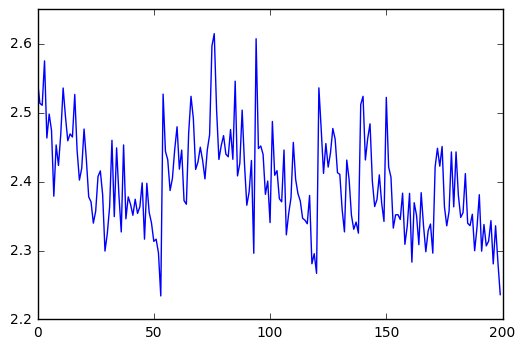

In [19]:
plt.plot(trainHist[-200:])

In [50]:
np.random.choice(vocab_size,num_steps)

array([72, 32, 15, 23,  0, 59, 19, 18, 26, 11, 46, 30, 27, 28, 79, 25, 17,
       24, 41, 58, 48, 62, 18,  3, 21])

In [81]:

#prev.tolist()

"eoa aaa'eaesa \nyFO .I \n ArMMhy AAIA  .Sae. ee \nEiie\nAaeea  I.... a .E   a\nan ln\n\nrRieei  E r\ns\neuaa eh R.e\n\n\naas.... oue\nC...uiiNE\nHea   Sah.  uTE\n\nNaled u\naAl.iC\n\n.a\nI Et anee\nA\n.E..  .ss yYaea'e\n.\n\nnO Aia. eoa laEHaiys,S..\neaN oeU rr.y. e.san IaS   \n\n\n\nei ,..aee\nnu aMY\nI\n\nasaily o\nay.e\nHAAE n..E   IYa\n...a.. eieao\neuea\nS\n\nrAee . SEEEE E ..  \n LR tiwIEEEOE YE  i.e..  \n..\ns \n  E IC\ns R.. Ue.i.eae  \nCEES \n\n\na\nh\nee\nYESE Aa. irheTaaui\n yy\nrnF L\n.  .\n\ns.IAOY\nEEMD,. .Ma\n  e.Y\n\n\nn.aueiaea \n.Ha .\n\n.n.eEEEEIY y\ne\n.\ne. .R .\nAa \ne \n eaa\n  \n A\na.....\nas   a\n\nNN .\nSO . A.\n\n A\n. Ans  Iaeaars Uss, uEaE \n\n Ae. aP\nn\n\norFN a.e\n...aacE.IAC... .N.naiOw..\nSiS ute \n\nANSau. .he\n \nAa.eET\nag \n \nHIa  a \n9T ..NOO h .cooeihae\nYE\nod. \nirOaP.,eeeuas.\n \n\nr ,u\naia..S  \n.syaae..or  \n\n9\n H\nT AMS.yt\neaeehsaaiEN i.y. A\n h..s eeued aa c\n,e\nSN\nyMaoaaeeo\nPEs. \n\naaaas   s  CeosturaaaauaS .Na   .Ea Y\nRIriiOa

In [88]:
digital_shakespeare = []
last_state = None
#prev = np.random.choice(vocab_size,(batch_size//num_steps,num_steps)).astype(np.float64)
#batch_generator = gen_batch(raw_text_enc,batch_size,num_steps)
#prev, _ = batch_generator.next()
prev = [25]
    
for i in range(10):
    if last_state == None:
        pred, last_state = sess.run([prediction, final_state],feed_dict={x: [[prev]], init_state: training_state})
    else:
        pred, last_state = sess.run([prediction, final_state],feed_dict={x: [[prev]], init_state: last_state})
    
    #prev = np.apply_along_axis(get_num, , pred)
    print(pred)
    #prev = np.argmax(pred,axis=2)
    #digital_shakespeare += "".join([rev_trans_dic[i] for i in prev.flatten().tolist()])
    #choice_char = rev_trans_dic[np.random.choice(a = range(vocab_size), p = prob_array)]
    
    #digital_shakespeare += "".join(np.apply_along_axis(my_func, 1, pred).flatten().tolist())

        
        
#print(np.argmax(pred,axis=2))
#print(pred.shape)
#
#digital_shakespeare += "".join(np.apply_along_axis(my_func, 1, pred).flatten().tolist())

ValueError: Cannot feed value of shape (1, 1, 1) for Tensor u'Placeholder:0', which has shape '(?, 25)'

In [87]:
print("".join(digital_shakespeare))

s   id ahnc e tnd thesk tn ne tod  tith the  
         T                 U    Ide yne  oire yng   tie oett oheu hheat      Iofethe shef the srarth s tyshre 
    Alhse s te ues  tove  tot  ng tet te h  otde     Rdote ng toomt yoo sitd  th theue tne toeas     Ie  te rt  ns togrrl  tia hout oheu hrls       He setnd dns tinge  htove  the  th tove 
    Riteleys  op ne etii houtetheu hn      Humreat tnm.rptf thcbeaot ton tetot tike 
    Ar Civeng thuce.ctseth the shef tnlne   o
 heu hn the shef the sh lththef to t oeakive    l ha  tau tien tomure ton y the  oh te troe,     I n tnceso ile tntsoston tetheu hotve 
 
     The s gm   te rth oast te th eer tith the        Thich as   tike  the aaertl ryth ae 
     
             t       U    heut tenr  teen tith trntle airdntos troie     he cire y trre hiine tner  tnesto h aeaaey    hsliteac the choegg  th the siry thye      Reowhet tndeinsaiach toir iolouh ancerl     Ir tovexe
epsilg ohme tiav  thcb nstf     humise ns titd s tnd tomserrd  aes the e

In [75]:
prev.shape

(64, 25)